## 2 - Price analysis

We are interested in seeing how our customers reacted to different pricing.
The customers are randomly sampled and assigned to two groups, high price, old price.
We would like to see the results.
Did we need this amount of information to reach this result?

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
demographic = pd.read_csv('data/price analysis/user_table.csv')

In [11]:
demographic.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [14]:
demographic.describe(include=['O']) # users are from 923 cities in US

,city,country
count,275616,275616
unique,923,1
top,New York,USA
freq,25748,275616


In [91]:
test = pd.read_csv('data/price analysis/test_results.csv')
test['date'] = pd.to_datetime(test['timestamp'], errors='coerce')
test.set_index('date', inplace=True)

In [110]:
test['sale'] = test['price'] * test['converted']

In [111]:
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,sale
date,,,,,,,,,
2015-05-08 03:38:34,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,0
2015-05-10 21:08:46,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,0
2015-04-04 15:01:23,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,0
2015-05-07 07:26:01,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,0
2015-05-24 11:04:40,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,0


``timestamp``: when the user is landed

``source``: whether it is adds/search engine/friends referal

``operative system``: operating system the user is using

``test``: whether the user has seen high or low price

``converted``: user has bough the product

First let's check the test results. In other words, we are interested in seeing whether test and sales are dependant.

In [113]:
test.groupby('test').sale.agg(['mean','count'])

,mean,count
test,,
0,0.776734,202727
1,0.916843,114073


We can see that the average sales per person is higher for the new users. However, we also see that in total our user base shrinks when we increase the price.

In [114]:
test.groupby('test').converted.agg(['mean','count'])

,mean,count
test,,
0,0.019904,202727
1,0.015543,114073


In [18]:
from statsmodels.stats.proportion import proportions_ztest

In [115]:
converted_on_test = int(114073 * 0.916)
total_observations = 114073
null_value = (0.7767* 202727 + 0.9168 * 114073) / (202727 + 114073)
stats, p_val = proportions_ztest(converted_on_test, total_observations, null_value)

In [116]:
print("significant" if p_val < 0.05 else "insignificant")

significant


We can also perform a hacker statistics using permutation to calculate this p-value. This is very helpful in general. The idea is borrowed from [here](https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2/introduction-to-hypothesis-testing?ex=7).

Simulated p-value is:	 0.0


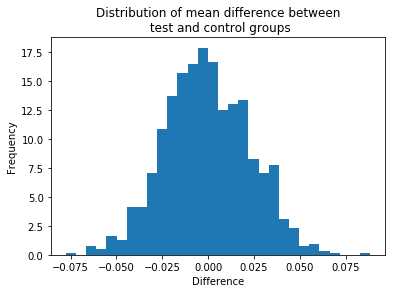

In [118]:
def draw_perm_reps(data1, data2, size):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data1, data2)

        # Compute the test statistic
        perm_replicates[i] = np.mean(perm_sample_1) - np.mean(perm_sample_2)

    return perm_replicates


test_group = test.loc[test.test == 1, 'sale'].values
control_group = test.loc[test.test == 0, 'sale'].values

# calculate the test statistics = mean difference
observed_diff = np.mean(test_group) - np.mean(control_group)
# concatenate test and control group
null_diff_dist = draw_perm_reps(test_group, control_group, 1000)
_ = plt.hist(null_diff_dist, bins=30, normed=True)
plt.title("Distribution of mean difference between\n \
test and control groups")
plt.xlabel('Difference')
plt.ylabel('Frequency')
# calculate the proportion of data that is smaller than this test statistics
p_val = np.sum(null_diff_dist > observed_diff) / len(null_diff_dist)

print('Simulated p-value is:\t', p_val)

Simulation and analytica results state that there is a signficant drop in sales when the price is increased. Test results demonstrate significance in the difference between old and new price. The users do not like the new result in total. However, let's take a look at different cluster of users (segments) and analyze their behaviour agains this price.

### segment analysis

In [120]:
test.groupby(['source', 'test']).sale.agg(['mean','count'])

mean  count
source          test                 
ads-bing        0     0.520570  14609
                1     0.564013   8264
ads-google      0     0.879622  37864
                1     1.157239  21515
ads-yahoo       0     0.655666   4818
                1     0.661483   2765
ads_facebook    0     0.923575  34099
                1     0.993678  19297
ads_other       0     0.600653  19284
                1     0.733384  10592
direct_traffic  0     0.529296  38759
                1     0.595518  21598
friend_referral 0     1.628626  13135
                1     1.974471   7560
seo-bing        0     1.169415   1334
                1     0.792430    819
seo-google      0     0.685671  15102
                1     0.942772   8073
seo-other       0     0.682119   5889
                1     0.735093   3371
seo-yahoo       0     0.759798   4363
                1     0.617304   2485
seo_facebook    0     0.680350  13471
                1     0.801009   7734

There seems to be a consistent increase in the sales across different sources. However, there are a few exception, e.g., customers that search through bing, and yahoo. It is suggested that these customers are shown the previous price to increase the sales. They might also be revealing a demographic that needs to be studied further.

In [121]:
test.groupby(['device', 'test']).sale.agg(['mean','count'])

mean   count
device test                  
mobile 0     0.775765  120481
       1     0.951887   65990
web    0     0.778153   82246
       1     0.868748   48083

Both device types demonstrate increase in average sales when shown new price.

In [123]:
test.groupby(['operative_system', 'test']).sale.agg(['mean','count'])

mean  count
operative_system test                 
android          0     0.639100  48210
                 1     0.728531  26725
iOS              0     0.920233  61855
                 1     1.179054  33610
linux            0     0.600816   2207
                 1     0.000000   1928
mac              0     0.994929  16366
                 1     1.251864   8719
other            0     0.546104  10498
                 1     0.651420   5706
windows          0     0.729521  63591
                 1     0.825385  37385

There is again a consistent increase in sales across different operating systems. There are a few points to notice; linux users didnt but new product. This is something that the engineering team should look into. There might be an issue in the product page for linux users.

### Time series analysis 
Let's check how the convertion rate has changed over time, daily.

In [136]:
control_series = test.loc[test.test == 0, 'sale'].resample('W').mean() * 100
test_series = test.loc[test.test == 1, 'sale'].resample('W').mean() * 100
total = pd.concat([control_series, test_series], axis = 1)
total.columns = ['control_sale', 'test_sale']

(array([2357, 2362, 2366, 2370], dtype=int64),
 <a list of 4 Text xticklabel objects>)

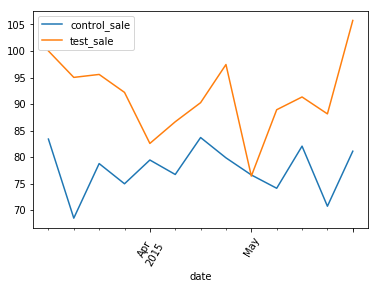

In [137]:
total.plot()
plt.xticks(rotation = 60)

There is a consisdent increase in the sales throughout the four months period.

## Conclusion:
   
The data suggests that in general the total sales increases when going from lower price to higher price. However, at the same time, the conversion rate decreases which means we might have a shrinking user base. Moreover, there are a few segments that have decrease in sales, e.g., customers that search through bing, and yahoo. Moreover, since we saw that a few weeks of data also shows similar results. So we do not need this amount of data to reach a conclusion.

## Next step
It is suggested taht for similar experiment, to take some time and calculate the total number of participants.

#### Assumptions for test
Assume our base sales per person is equal to the status quo in our experiment = 0.777 $ per user. Let's also assume we need at least 15% increase in the average sales to consider this experiment as a successful experiment. Finally, we also will assume that the standard deviation of the population is equal to the standard deviation of status quo and we need the new observation to be at least 3 standard deviation away from the norm (we really want to be confident - CL = 99.73%.

In [142]:
sales_average = np.mean(control_group)
effect_size = 15 / 100 * sales_average
sales_std = np.std(control_group)
z_crit = 3
n = int(3 * sales_std / effect_size) ** 2
print("Such experiment requires {} number of participants".format(n))

Such experiment requires 19600 number of participants


Therefore, assuming that on average the number of landings on the website is constant, we need the following number of days to experiment and reach this goal.

In [145]:
n_days_current = test_series.shape[0] * 7 # week to days
n_obs_current = test.shape[0] # total number of observations
user_average_landing = (n_days_current / n_obs_current) # average daily landing
required_days = int(user_average_landing * n) # n from the previous cell
print('We need approximately {} number of days to run the test'.format(required_days))

We need approximately 5 number of days to run the test


We can always use a safety factor, e.g. 5 to make sure all the corner cases are covered and also we have enough data to study segments.